# GILL Inference Examples

This is a notebook showcasing how to run GILL for image generation, image retrieval, and text generation, some of the tasks that GILL is capable of. It reproduces several examples in our paper, [Generating Images with Multimodal Language Models](https://arxiv.org/abs/2305.17216).

For reproducibility, all examples in this notebook use greedy (deterministic) decoding. However, it is possible to change to nucleus sampling for more diverse and higher quality outputs (used for some of the figures in the paper) by changing the `temperature` and `top_p` parameters in the `generate()` function.

At least 22GB of GPU memory is required to run this model, and it has only been tested on A6000, V100, and 3090 GPUs.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import torch
from tqdm import notebook

from gill import models
from gill import utils

## Load the Model

Note that you will need to download the [CC3M image embeddings](https://drive.google.com/file/d/1e9Cimh2dpWN8Cbgx_mSR-954Dr-DS-ZO/view) and place them in the `checkpoints/gill_opt/` folder, in order to use GILL's image retrieval capabilities. If this embedding file does not exist, the model will still run, but it will exclusively generate images (as opposed to deciding when to retrieve or generate).

In [2]:
# Download the model checkpoint and embeddings to checkpoints/gill_opt/
model_dir = 'checkpoints/gill_opt/'
model = models.load_gill(model_dir)

cc3m.npy files do not exist in checkpoints/gill_opt/. Running the model without retrieval.
Adding [IMG0] token to vocabulary.
Before adding new token, tokenizer("[IMG0]") = {'input_ids': [10975, 3755, 534, 288, 742], 'attention_mask': [1, 1, 1, 1, 1]}
After adding 1 new tokens, tokenizer("[IMG0]") = {'input_ids': [50266], 'attention_mask': [1]}
Adding [IMG1] token to vocabulary.
Before adding new token, tokenizer("[IMG1]") = {'input_ids': [10975, 3755, 534, 134, 742], 'attention_mask': [1, 1, 1, 1, 1]}
After adding 1 new tokens, tokenizer("[IMG1]") = {'input_ids': [50267], 'attention_mask': [1]}
Adding [IMG2] token to vocabulary.
Before adding new token, tokenizer("[IMG2]") = {'input_ids': [10975, 3755, 534, 176, 742], 'attention_mask': [1, 1, 1, 1, 1]}
After adding 1 new tokens, tokenizer("[IMG2]") = {'input_ids': [50268], 'attention_mask': [1]}
Adding [IMG3] token to vocabulary.
Before adding new token, tokenizer("[IMG3]") = {'input_ids': [10975, 3755, 534, 246, 742], 'attention_mask

/scratch/jingyuk/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Freezing the LM.
Restoring pretrained weights for the visual model.


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.1.mlp.fc2.bias', 'text_model.encoder.layers.7.self_attn.k_proj.weight', 'text_model.encoder.layers.6.mlp.fc1.bias', 'text_model.encoder.layers.6.mlp.fc1.weight', 'text_model.encoder.layers.4.self_attn.k_proj.bias', 'text_model.encoder.layers.3.self_attn.q_proj.bias', 'text_model.encoder.layers.3.self_attn.out_proj.weight', 'text_model.encoder.layers.8.self_attn.out_proj.weight', 'text_model.encoder.layers.0.self_attn.v_proj.weight', 'text_model.encoder.layers.5.layer_norm1.weight', 'text_model.encoder.layers.7.layer_norm1.weight', 'logit_scale', 'text_model.encoder.layers.3.self_attn.v_proj.bias', 'text_model.encoder.layers.7.self_attn.v_proj.bias', 'text_model.encoder.layers.7.mlp.fc2.weight', 'text_model.encoder.layers.0.mlp.fc1.bias', 'text_model.encoder.layers.3.self_attn.k_proj.weight', 'text_model.encoder.layers.4.mlp.fc1.bias', 'text_

Freezing the VM.


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Loading decision model...


# Image Generation

GILL can generate images conditioned on image and text inputs. Shown are several examples for various text prompts and image + text prompts.

  0%|          | 0/50 [00:00<?, ?it/s]

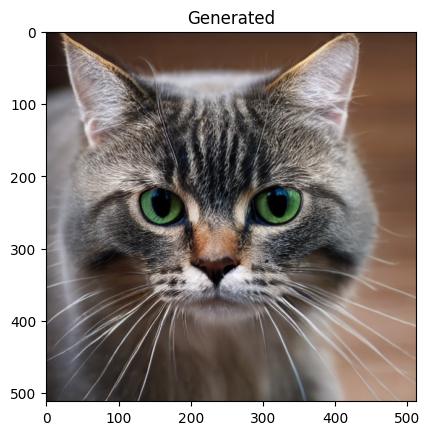

  0%|          | 0/50 [00:00<?, ?it/s]

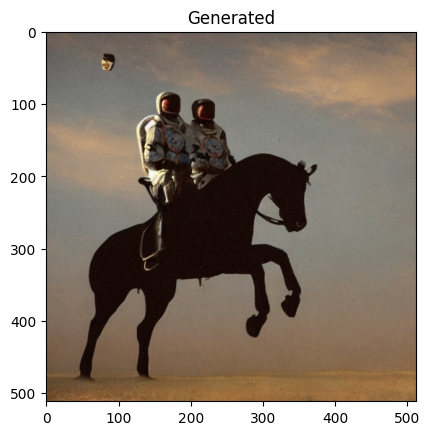

  0%|          | 0/50 [00:00<?, ?it/s]

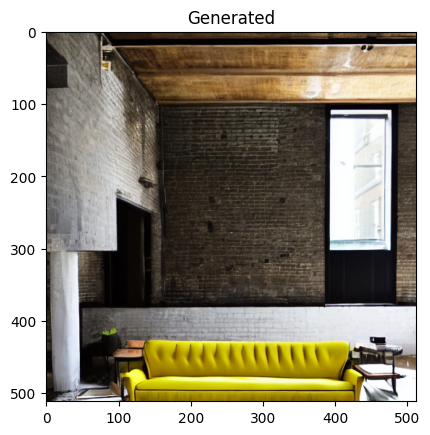

  0%|          | 0/50 [00:00<?, ?it/s]

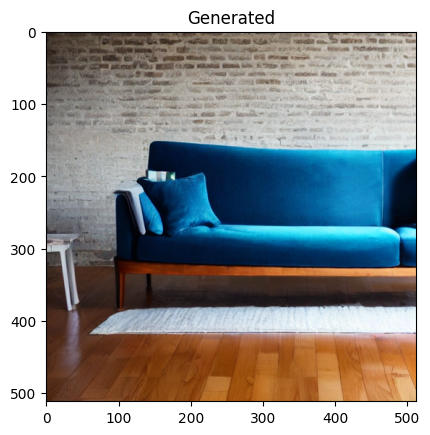

  0%|          | 0/50 [00:00<?, ?it/s]

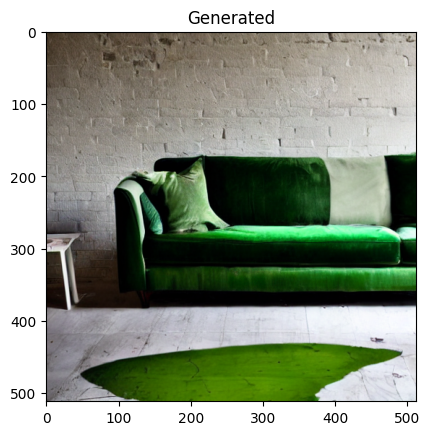

In [3]:
sofa_img = utils.get_image_from_url('https://images.pexels.com/photos/1866149/pexels-photo-1866149.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1')

# Generate for a few types of text prompts and image + text prompts.
for prompt in [
    ['a picture of a cat'],
    ['an astronaut riding a horse on mars'],
    [sofa_img, 'a picture of this but in yellow'],
    [sofa_img, 'a picture of this but in blue'],
    [sofa_img, 'a picture of this but in green'],
]:
    g_cuda = torch.Generator(device='cuda').manual_seed(1337)
    return_outputs = model.generate_for_images_and_texts(
        prompt, num_words=2, ret_scale_factor=100.0, generator=g_cuda)

    # Show either the generated or retrieved image, depending on the decision model outputs.
    if return_outputs[1]['decision'][0] == 'gen':
        plt.imshow(return_outputs[1]['gen'][0][0])
        plt.title('Generated')
    else:
        plt.imshow(return_outputs[1]['ret'][0][0].resize((512, 512)))
        plt.title(f"Retrieved")
    plt.show()

# Multimodal Dialogue

GILL can also generate dialogue-like text. We define some helper functions for displaying outputs:

In [4]:
def generate_dialogue(prompts: list, system_message: str = None, num_words: int = 32,
                      sf: float = 1.0, temperature: float = 0.0, top_p: float = 1.0,
                      divider_count: int = 40):
    g_cuda = torch.Generator(device='cuda').manual_seed(1337)

    full_outputs = []
    if system_message:
        print("Adding system message")
        full_inputs = [system_message]
    else:
        full_inputs = []

    for prompt_idx, prompt in notebook.tqdm(enumerate(prompts), total=len(prompts)):
        formatted_prompt = []
        for p in prompt:
            if type(p) == Image.Image:
                full_inputs.append(p)
                formatted_prompt.append(p)
            elif type(p) == str:
                full_inputs.append(f'Q: {p}\nA:')
                formatted_prompt.append(f'User: {p}')
        formatted_prompt.append('=' * divider_count)  # Add divider

        return_outputs = model.generate_for_images_and_texts(
            full_inputs, num_words=num_words, ret_scale_factor=sf,
            generator=g_cuda, temperature=temperature, top_p=top_p)

        # Add outputs
        output_text = return_outputs[0].replace('[IMG0] [IMG1] [IMG2] [IMG3] [IMG4] [IMG5] [IMG6] [IMG7]', '')
        full_inputs.append(output_text + '\n')

        formatted_return_outputs = []
        for p in return_outputs:
            if type(p) == str:
                p_formatted = p.replace('[IMG0] [IMG1] [IMG2] [IMG3] [IMG4] [IMG5] [IMG6] [IMG7]', '')
                formatted_return_outputs.append(f'GILL: {p_formatted}')
            else:
                formatted_return_outputs.append(p)
        formatted_return_outputs.append('=' * divider_count)  # Add divider

        full_outputs.extend(formatted_prompt + formatted_return_outputs)

    return full_outputs


def display_conversation(full_outputs):
    # Display conversation.
    for p in full_outputs:
        if type(p) == Image.Image:
            plt.figure(figsize=(4, 4))
            plt.imshow(p)
            plt.show()
        elif type(p) == str:
            print(p)
        elif type(p) == dict:
            # Decide whether to retrieve or generate
            decision_probs = [f'{s:.3f}' for s in p['decision'][1]]
            if p['decision'][0] == 'gen':
                gen_img = p['gen'][0][0].resize((512, 512))
                # Generate
                plt.figure(figsize=(4, 4))
                plt.imshow(gen_img)
                plt.title(f'GENERATED (p={decision_probs})')
            else:
                ret_img = p['ret'][0][0].resize((512, 512))
                # Retrieve
                plt.figure(figsize=(4, 4))
                plt.imshow(ret_img)
                plt.title(f'RETRIEVED (p={decision_probs})')
            plt.show()
        else:
            raise NotImplementedError(p)

The inputs to the model can be an interleaved image and text sequence. Shown is one example from our paper, with a cupcake image input and a question (note that the word "cupcake" is never explicitly mentioned, but GILL infers it from the image).

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

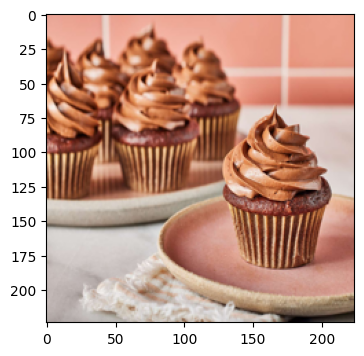

User: How should I publicise these at the market?
GILL:  I think it's a good idea to have a sign that says "free cupcakes ". 


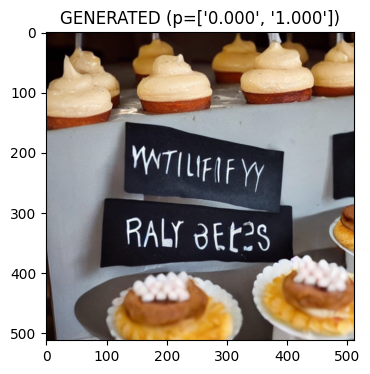

In [5]:
sf = 1.4  # Scaling factor: increase to increase the chance of returning an image
temperature = 0.0  # 0 means deterministic, try 0.6 for more randomness
top_p = 1.0  # If you set temperature to 0.6, set this to 0.95
num_words = 32

prompts = [
    [
        utils.get_image_from_url('https://www.allrecipes.com/thmb/riDYvmalWk8QgJDBT_pZRkpfpR0=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/17377-chocolate-cupcakes-DDMFS-4x3-622a7a66fcd84692947794ed385dc991.jpg'),
        'How should I publicise these at the market?'
    ],
]

full_outputs = generate_dialogue(prompts, num_words=num_words, sf=sf, temperature=temperature, top_p=top_p)
display_conversation(full_outputs)

# Image-to-Text Example

GILL can also generate text conditioned on image and text inputs. This is helpful for tasks such as image captioning or VQA.

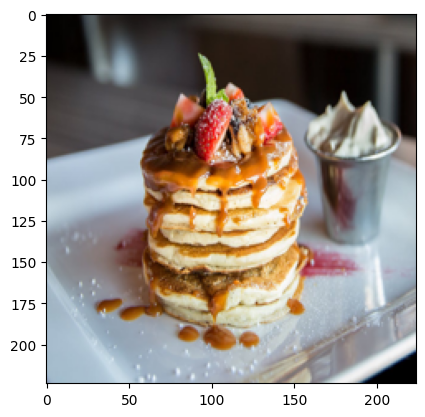

 a stack of pancakes with maple syrup and strawberries.


In [6]:
pancakes_img = utils.get_image_from_url('https://images.pexels.com/photos/376464/pexels-photo-376464.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1')
prompts = [
    pancakes_img,
    'A picture of'
]

plt.imshow(pancakes_img)
plt.show()

return_outputs = model.generate_for_images_and_texts(prompts, num_words=16, min_word_tokens=16)
print(return_outputs[0])